<a href="https://colab.research.google.com/github/gdewael/teaching/blob/main/predmod/RNNs/PClab_RNNs_SOLVED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNNs

## Introduction

Recurrent networks strictly operate on 1-D sequences. They can be used for a variety of tasks, pictured below:

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" width = 500>

Examples of the settings in the picture:
- one to one: vanilla MLPs that map a fixed size 1-D vector to a 1-D vector for classification or regression
- one to many: Image captioning, given an input embedding (obtained with a CNN), a textual caption of variable length is generated.
- many to one: (1) Sentence classification such as sentiment analysis or (2) image generation from text: in both cases variable input texts are given as input and a fixed dimensional output is generated.
- many to many: (1) machine translation of a variable-length sentence to another variable-length sentence or (2) transcription of a variable-length .mp3 audio to a variable length text.
- many to many (1to1 correspondence): (1) Video classification: one label for a variable number of frames in the video (the video frame embedding can be obtained with a CNN and then input into a RNN), (2) autoregressive language modeling: trying to predict the next word in the sentence, for generative purposes or (3) word classification: classify every word as belonging to a category.

Note that these settings are not exclusive to recurrent neural networks. In fact, any network type that works on variable input sequences can be used towards these ends. Most famously of which are of course, Transformers, which have all but replaced RNNs in NLP and many other fields. An explanation and implementation of transformers is out of the scope of this course. It suffices to know that RNNs process input sequence sequentially through memory cells, whereas transformers do it in parallel through an $n \times n$ attention matrix. Other than RNNs and Transformers, convolutional networks can also be used on variable length inputs: a 1D kernel can equally well convolve over a sequence of length $100$ as $1000$. It is only because of the linear layers at the end for classification requiring a specific number of input nodes that typical CNNs become applicable on only one specific input size.

## Partim 1: Autoregressive modeling

Autoregressive modeling is the task of trying to predict the next token in a sequence given which tokens came before it: $P(x_i | x_{i-1}, x_{i-2}, ..., x_1)$.

In this PC-lab we will explore autoregressive modeling on a dataset close to home: a dataset published by the city of Ghent on how many cyclists pass by the bicycle counter at the Coupure.

<img src="https://images0.persgroep.net/rcs/4cQwm-ofvb3eyIKMWnNf5axxLHg/diocontent/217261403/_fitwidth/694/?appId=21791a8992982cd8da851550a453bd7f&quality=0.8" width = 500>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/gdewael/teaching/main/predmod/RNNs/fietstelpaal-coupure-links-2022-gent.csv", "./data.csv")

data_raw = pd.read_csv("data.csv", sep = ";")

data_raw

,Code,Locatie,Datum,Uur5Minuten,Ordening,Totaal,Tegenrichting,Hoofdrichting
0,COU,Coupure-Links,2022-01-01,0:00:00,2022-01-01T00:00:00+01:00,0.0,0.0,0.0
1,COU,Coupure-Links,2022-01-01,0:05:00,2022-01-01T00:05:00+01:00,2.0,1.0,1.0
2,COU,Coupure-Links,2022-01-01,0:10:00,2022-01-01T00:10:00+01:00,1.0,0.0,1.0
3,COU,Coupure-Links,2022-01-01,0:15:00,2022-01-01T00:15:00+01:00,0.0,0.0,0.0
4,COU,Coupure-Links,2022-01-01,0:20:00,2022-01-01T00:20:00+01:00,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...
61051,COU,Coupure-Links,2022-07-31,23:35:00,2022-07-31T23:35:00+02:00,7.0,3.0,4.0
61052,COU,Coupure-Links,2022-07-31,23:40:00,2022-07-31T23:40:00+02:00,3.0,3.0,0.0
61053,COU,Coupure-Links,2022-07-31,23:45:00,2022-07-31T23:45:00+02:00,6.0,3.0,3.0
61054,COU,Coupure-Links,2022-07-31,23:50:00,2022-07-31T23:50:00+02:00,3.0,1.0,2.0


For the PC lab, we will aggregate the individual 5-minute observations to hour-level observations. The following code processes the data:

Think for yourself what the advantages and disadvantages are of working at this reduced temporal resolution.

In [2]:
data_raw["Date_hour"] = data_raw["Ordening"].str.split(':', expand = True)[0]
data_grouped = data_raw.groupby("Date_hour").sum()
data = pd.concat([data_grouped.index.to_series().str.split('T', expand = True), data_grouped["Totaal"]], axis = 1).reset_index(drop = True)
data.columns = ['Date', 'Hour', 'n']
data = pd.concat([data, pd.DataFrame([["2022-03-27", "02", 0.0]], columns = data.columns)], axis = 0).sort_values(["Date", "Hour"]) # ignore this line, this is because there is no observation for this date/hour
data["n_norm"] = data["n"] / data["n"].max() # we min-max normalize here for learning stability
data

,Date,Hour,n,n_norm
0,2022-01-01,00,30.0,0.018484
1,2022-01-01,01,110.0,0.067776
2,2022-01-01,02,117.0,0.072089
3,2022-01-01,03,148.0,0.091189
4,2022-01-01,04,150.0,0.092421
...,...,...,...,...
5082,2022-07-31,19,217.0,0.133703
5083,2022-07-31,20,151.0,0.093038
5084,2022-07-31,21,156.0,0.096118
5085,2022-07-31,22,116.0,0.071473


Architecturally, autoregressive modeling of a timeseries looks like this:

<img src="https://raw.githubusercontent.com/gdewael/teaching/main/predmod/RNNs/AR.png" width = 500>

For every point in the timeseries, the *input token* consists of the value at that timepoint and, optionally, extra covariates pertaining to that timepoint. Conceptually, this is similar to the channels in a CNN, as there we also had input tokens (e.g. pixels) with multiple values (e.g. the 3 RGB values) per token. In our case, extra covariates could be for example the hour at which that timepoint was taken. This input sequence will go into the RNN, which will keep a hidden layer which acts as a memory bank. The memory bank of every input will consist of a combination of the information at that time point and the information coming in from the memory cell at the previous time point. The specific way this information is brought together depends on the specific construction of the RNN. We refer you to the theory lectures for details. The most popular constructions are the LSTM and the GRU memory cells. For every timestep, the model outputs a vector which (for this purpose) needs to be linearly recombined to one number as our goal is to predict the value of the next timestep (i.e. a regression task).

Code-wise, it is important to know that for a given sequence, we have an input $x$ consisting of the timepoints in that sequence, and an output $y$, consisting of the same points, but **shifted one time-step to the left**. **Because of the directionality of the RNN, for every time-step, it will predict the next point given only the preceding ones.**

In this PC-lab, we will use the hour of the timepoint as covariate.

For training, we can't put all days in to our model as one sample. Just like the reason for doing batches in other networks is that: it is more computationally efficient, and it allows us to have training steps on different parts of data with some stochasticity to it, allowing us to jump out of local minima.

**For RNN, another reason is that our "actual" neural network depth is essentially decided by our input length**, so if we send in a sample containing a thousand input tokens, we also backpropagate through a thousand layers, and our computers will surely crash. In addition, it is not reasonable to assume the number of cyclists hundreds of days past still influences the number of cyclists now. So, the problem of batching our sequence becomes one of weighing two factors: how long of a sequence can our model handle, and how much context (in number of preceding tokens) do our models need for prediction?

Here we will take a batch size of 48 as a default, meaning that our samples will always coincide with two consecutive days.

In [3]:
def generate_batches(sequence, seqlen = 48):
    batches = []
    for i in np.arange(0, len(sequence) - seqlen, seqlen):
        batches.append(sequence[i:i+seqlen])
    return torch.stack(batches)

batches = generate_batches(torch.tensor(data[["Hour", "n_norm"]].values.astype(np.float32)))

Let's see how a sample looks like:

In [4]:
batches.shape

torch.Size([105, 48, 2])

In [5]:
batches[0]

tensor([[0.0000e+00, 1.8484e-02],
        [1.0000e+00, 6.7776e-02],
        [2.0000e+00, 7.2089e-02],
        [3.0000e+00, 9.1189e-02],
        [4.0000e+00, 9.2421e-02],
        [5.0000e+00, 6.3463e-02],
        [6.0000e+00, 4.3130e-02],
        [7.0000e+00, 4.8059e-02],
        [8.0000e+00, 2.3413e-02],
        [9.0000e+00, 2.3413e-02],
        [1.0000e+01, 3.2039e-02],
        [1.1000e+01, 6.3463e-02],
        [1.2000e+01, 7.5786e-02],
        [1.3000e+01, 8.1947e-02],
        [1.4000e+01, 1.0351e-01],
        [1.5000e+01, 1.2138e-01],
        [1.6000e+01, 1.2877e-01],
        [1.7000e+01, 8.7492e-02],
        [1.8000e+01, 6.5311e-02],
        [1.9000e+01, 5.4837e-02],
        [2.0000e+01, 4.1282e-02],
        [2.1000e+01, 4.8675e-02],
        [2.2000e+01, 4.3130e-02],
        [2.3000e+01, 2.4646e-02],
        [0.0000e+00, 1.3555e-02],
        [1.0000e+00, 5.5453e-03],
        [2.0000e+00, 2.4646e-03],
        [3.0000e+00, 2.4646e-03],
        [4.0000e+00, 1.8484e-03],
        [5.000

We could give our input to the model like this, as the hour is a numerical value which can be interpreted using linear layers. It would make more sense to treat the hour variable as categorical and encode it using dummy variables (one-hot encoding).

In [6]:
one_hot_hour = torch.nn.functional.one_hot(batches[:, :, 0].long())

one_hot_hour.shape

torch.Size([105, 48, 24])

In [7]:
batches = torch.cat([batches[:, :, [1]], one_hot_hour], axis = 2)

In [8]:
batches.shape

torch.Size([105, 48, 25])

In [9]:
batches[0]

tensor([[0.0185, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0678, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0721, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0450, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0394, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0283, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

### RNNs in PyTorch

In this PC-lab we will use the GRU, but note that other RNN-types work similarly in PyTorch.

[Documentation for the GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

Extra note: The weird shape expectations (such as not expecting batches to come first by default) are a consequence of optimizations that PyTorch has implemented so the RNNs run efficiently on data with variable input sequence lengths (such as sentences). For this PC lab, we have batched our sequences so that they have constant sequence length, so we can add the argument `batch_first = True`.

Let's create a GRU and some toy data to see how it all works:

In [10]:
gru = nn.GRU(input_size = 64, hidden_size = 512, batch_first = True)

In [11]:
x = torch.randn(2, 50, 64)
output, h_n = gru(x)
output.shape, h_n.shape

(torch.Size([2, 50, 512]), torch.Size([1, 2, 512]))

Explanation of the outputs: `h_n` is the hidden representation of the last hidden memory cell. It can be seen as a summarized representation of the content of the whole input (if one wants a single output for a whole sequence as in e.g. sentence classification). `output` will return the output representation of the RNN for every input token. (Look back at the picture in the introduction of this part of the PC lab (Section 2.1) for more intuition as to when to use what outputs of the RNN)

For autoregressive modeling of time series, we should have an output for every input, mainly: the prediction of the next timepoint. For our purpose, we are interested to predict a single output per timepoint, whereas we can see that this is not the case for our GRU model as it is now. We can remedy this with a simple linear layer 

<div class="alert alert-success">

<b>EXERCISE:</b> 
<p> Implement an autoregressive GRU for cycler forecasting by completing the code below. The model should contain a recurrent layer, and a layer that takes the outputs of the GRU at each timestep and manipulates their dimensions so that the output dimensionality of each token is equal to one. Keep in mind how many input variables we have in our dataset. (Look at the $batches$ variable).
</p>

</div>

Test your model with some toy data down below.



In [12]:
class CyclerForecaster(nn.Module):
    def __init__(self, input_dim = 25, hidden_dim = 64):
        super().__init__()
        self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, batch_first = True)
        self.output_head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        output, _ = self.gru(x)
        return self.output_head(output)

In [13]:
model = CyclerForecaster()

x = torch.randn(2, 48, 25)

y = model(x)

y.shape

torch.Size([2, 48, 1])

To create an input and an output, we have to do the above-mentioned shifting. In practice, this means that we take all but the last timepoints to create X, and all but the first timepoints to create Y, hence creating shifted X,y pairs.

Additionally, for y, we only want to keep the first variable, meaning the number of cyclists itself.

In [14]:
X = batches[:, :-1]

y = batches[:, 1:]
y = y[:, :, [0]]

print(X.shape, y.shape)

torch.Size([105, 47, 25]) torch.Size([105, 47, 1])


Data splitting:

In [15]:
X_train = X[:int(batches.shape[0] * 0.80)]
X_test = X[int(batches.shape[0] * 0.80):]

y_train = y[:int(batches.shape[0] * 0.80)]
y_test = y[int(batches.shape[0] * 0.80):]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True)

Note that we are just taking the first 80% of the data as training and the last 20% as validation set. Normally, we shuffle our data so that we are not biased. In this case, however, we can make a case for doing it our way: because the samples are ordered by day and month, the last samples will be from the summer months, where we may expect different patterns (June: exams, July: vacations).

<div class="alert alert-success">

<b>EXERCISE:</b> 
<p> Implement the training loop for the Cycler Forecaster using the same principles from last PC labs. Keep in mind that unlike previous PC labs, we are now training a regression task. You will also need to up the number of epochs as our dataset is quite small and each epoch only constitutes a small number of training steps.
</p>

</div>


In [16]:
N_EPOCHS = 250

model = CyclerForecaster()

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # SGD = stochastic gradient descent

for i in range(1, N_EPOCHS + 1):
    all_losses = []
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, y_batch) # Compute loss

        loss.backward()   # Calculate gradients
        optimizer.step()   # Update weights using defined optimizer

        all_losses.append(loss.item())
    train_loss = np.mean(all_losses)
    
    predictions = []
    true_labels = []
    losses = []

    with torch.no_grad():
        model.eval()
        for batch in test_dataloader:
            X_batch, y_batch = batch

            y_hat_batch = model(X_batch)

            loss = loss_function(y_hat_batch, y_batch)

            losses.append(loss.item())
            predictions.append(y_hat_batch)
            true_labels.append(y_batch)

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)

    print(i, '\t', train_loss, np.mean(losses))

1 	 0.07990613173354756 0.03548333172996839
2 	 0.03620390915735201 0.01397782051935792
3 	 0.023840261877260426 0.014538462894658247
4 	 0.020364973101426254 0.009954212388644615
5 	 0.01778936961835081 0.009113934511939684
6 	 0.016016812148419293 0.007934603529671827
7 	 0.015079026279801672 0.008091913536190987
8 	 0.01391583223911849 0.007116456671307485
9 	 0.01333810846236619 0.00690631444255511
10 	 0.012533353726294908 0.006659166266520818
11 	 0.012438172135840763 0.006769891828298569
12 	 0.011429627595300024 0.006498307300110658
13 	 0.010900430000302467 0.006786893277118604
14 	 0.010552088772370056 0.006151698374499877
15 	 0.00986564244058999 0.006064617540687323
16 	 0.009538114875216375 0.005940134326616923
17 	 0.009240836624733427 0.0058334812832375365
18 	 0.00901061702858318 0.005758993017176787
19 	 0.008751683953133497 0.005902566170940797
20 	 0.008443512784486467 0.005719190929085016
21 	 0.008022053929215128 0.005572314995030562
22 	 0.00785370949994434 0.0056

To evaluate our model beyond looking at a loss function going down: we can look at the autoregressive results for a random test sample:

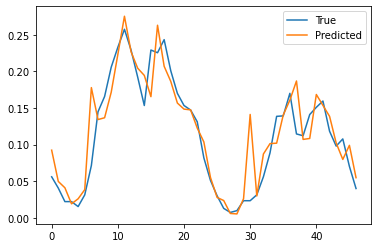

In [17]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(y_test[0])), y_test[0])
plt.plot(np.arange(len(y_test[0])), model(X_test[[0]]).detach().squeeze(0).numpy())
plt.legend(["True", "Predicted"])
plt.show()

You should see that at the beginning of the second day, the model overshoots its prediction by a wide margin. This is because most probably the next day is a weekend day. After that, for the prediction of the next step, we give it the true input of that (previously-wrongly predicted) timestep, and because it recognizes that by this low value it should be a weekend day, the subsequent predictions are also low.

This is not really forecasting though: at every timestep, we are predicting only one timestep (hour) in advance. To really do forecasting for a longer time limit, we should feed the predictions of the model back into the model, like this:

<img src="https://raw.githubusercontent.com/gdewael/teaching/main/predmod/RNNs/generation.png" width = 500>

To perform this, we will create a helper function that extracts the next step:

In [18]:
def generate_next_timestep(previous, model):
    with torch.no_grad():
        output = model(previous.unsqueeze(0))[0, -1]
    
    return output

def generate_n_timesteps(previous, model, n = 5):
    for _ in range(n):
        prediction = generate_next_timestep(previous, model)
        # to make a next prediction, we not only need to add the prediction but also the covariates (hour) to our next input:
        next_timestep_hour = nn.functional.one_hot((previous[-1, 1:].argmax() + 1) % 24, num_classes = 24) 
        new_input = torch.cat([prediction, next_timestep_hour])
        previous = torch.cat([previous, new_input.unsqueeze(0)])

    return previous[:, 0]

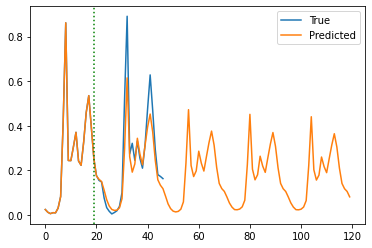

In [19]:
sample_index = 1
priming_points = 20
generate_steps = 100


plt.plot(np.arange(len(X_test[sample_index])), X_test[sample_index, :, 0])
predictions = generate_n_timesteps(X_test[sample_index, :priming_points], model, n = generate_steps).numpy()
plt.plot(np.arange(len(predictions)), predictions)
plt.axvline(x = priming_points-1, color = "green", linestyle = ":")
plt.legend(["True", "Predicted"])
plt.show()

<div class="alert alert-success">

<b>THOUGHT EXERCISE:</b> 
<p> Play around with the code for forecasting bicyclists by changing up which sample you forecast ("sample_index"), how much initial input points you give the model ("priming points") and how far in time it should generate after that ("generate steps"). Can you find obvious failure states? Can you think of ways how to remedy these failure modes?
</p>

</div>

Written answer:
If the priming point is a friday and the next day a weekend day, it will still predict high numbers for the weekend. Additionally, when generating a lot of days, after a while the same pattern is predicted for every day.

**Solution**: The model doesn't know what day of the week it is, resulting in a behavior in which the best the model can do is predict "the average day". One could encode more features for every timepoint in addition to just which hour it was, such as which day of the week it is. In addition, one could add weather and temperature variables to the model, so that the model can account for seasonal and weather impacts on the prediction. One could even go as far as adding an indicator variable that indicates whether a day is a Belgian holiday ...

## Partim 2: time series classification

In the next part, we will explore a many-to-one scenario. To keep things simple, we will work on the same dataset and try to predict from the series of a single day whether that day was a weekend or a weekday.

To do this, we first need to know which days were weekdays:

In [20]:
data

,Date,Hour,n,n_norm
0,2022-01-01,00,30.0,0.018484
1,2022-01-01,01,110.0,0.067776
2,2022-01-01,02,117.0,0.072089
3,2022-01-01,03,148.0,0.091189
4,2022-01-01,04,150.0,0.092421
...,...,...,...,...
5082,2022-07-31,19,217.0,0.133703
5083,2022-07-31,20,151.0,0.093038
5084,2022-07-31,21,156.0,0.096118
5085,2022-07-31,22,116.0,0.071473


Following code adds an indicator variable to the data that signifies if the date is a weekday or not. We'll use this as "y" values to predict

In [21]:
from datetime import datetime
def isweekday(date):
    return datetime.fromisoformat(date).weekday() < 5

data["isweekday"] = [int(isweekday(i)) for i in data["Date"]]
data 



,Date,Hour,n,n_norm,isweekday
0,2022-01-01,00,30.0,0.018484,0
1,2022-01-01,01,110.0,0.067776,0
2,2022-01-01,02,117.0,0.072089,0
3,2022-01-01,03,148.0,0.091189,0
4,2022-01-01,04,150.0,0.092421,0
...,...,...,...,...,...
5082,2022-07-31,19,217.0,0.133703,0
5083,2022-07-31,20,151.0,0.093038,0
5084,2022-07-31,21,156.0,0.096118,0
5085,2022-07-31,22,116.0,0.071473,0


With this data added, we can process our data into X and y:

In [22]:
batches = generate_batches(torch.tensor(data[["isweekday", "Hour", "n_norm"]].values.astype(np.float32)), seqlen = 24)
y = batches[:, 0, 0]
X = batches[:, :, 1:]

one_hot_hour = torch.nn.functional.one_hot(X[:, :, 0].long())
X = torch.cat([X[:, :, [1]], one_hot_hour], axis = 2)

In [23]:
X.shape, y.shape

(torch.Size([211, 24, 25]), torch.Size([211]))

Examine if the shapes are conforming to your expectations as to what we expect it to be for timeseries classification. What does every dimension in X and y signify?

In [24]:
X_train = X[:int(batches.shape[0] * 0.80)]
X_test = X[int(batches.shape[0] * 0.80):]

y_train = y[:int(batches.shape[0] * 0.80)]
y_test = y[int(batches.shape[0] * 0.80):]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True)

<div class="alert alert-success">

<b>EXERCISE:</b> 
<p> Implement a time series classification model by copying the code above and adapting it.

Steps you need to take:
- Change the RNN model so that it is adapted for many to one tasks
- Change the loss function for binary classification
- Implement a way to keep track of accuracies instead of only losses
</p>

</div>

You should be able to obtain an accuracy of at least 90%.

In [25]:
class TimeseriesClassifier(nn.Module):
    def __init__(self, input_dim = 25, hidden_dim = 64):
        super().__init__()
        self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, batch_first = True)
        self.output_head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, output = self.gru(x)
        return self.output_head(output[0])[:, 0]

In [26]:
N_EPOCHS = 250

model = TimeseriesClassifier()

loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # SGD = stochastic gradient descent

for i in range(1, N_EPOCHS + 1):
    all_losses = []
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, y_batch) # Compute loss

        loss.backward()   # Calculate gradients
        optimizer.step()   # Update weights using defined optimizer

        all_losses.append(loss.item())
    train_loss = np.mean(all_losses)
    
    predictions = []
    true_labels = []
    losses = []

    with torch.no_grad():
        model.eval()
        for batch in test_dataloader:
            X_batch, y_batch = batch

            y_hat_batch = model(X_batch)

            loss = loss_function(y_hat_batch, y_batch)

            losses.append(loss.item())
            predictions.append(y_hat_batch)
            true_labels.append(y_batch)

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)
    accuracy = ((predictions > 0) == true_labels).sum() / len(true_labels)

    print(i, '\t', train_loss, np.mean(losses), accuracy.item())

1 	 0.7070396429016477 0.6998802125453949 0.302325576543808
2 	 0.6950598756472269 0.6905413568019867 0.6976743936538696
3 	 0.6848838102249872 0.6812636256217957 0.6976743936538696
4 	 0.6744844118754069 0.6715247929096222 0.6976743936538696
5 	 0.663744276478177 0.6553774078687032 0.6976743936538696
6 	 0.6521510822432381 0.6427312990029653 0.6976743936538696
7 	 0.6403984484218416 0.6416286031405131 0.6976743936538696
8 	 0.6281639678137643 0.6331237355868021 0.6976743936538696
9 	 0.6187897948991685 0.6040387153625488 0.6976743936538696
10 	 0.6061773654960451 0.6169545749823252 0.6976743936538696
11 	 0.5979693602947962 0.6386270026365916 0.6976743936538696
12 	 0.5927645876294091 0.582097738981247 0.6976743936538696
13 	 0.5913568607398442 0.6118104656537374 0.6976743936538696
14 	 0.588970612911951 0.5788830071687698 0.6976743936538696
15 	 0.5876744219235012 0.5779206057389578 0.6976743936538696
16 	 0.5869252710115342 0.6118867049614588 0.6976743936538696
17 	 0.58566359395072

Let's plot all the test data and see what the model still got wrong. In the following code. Green timeseries are weekdays and blue timeseries are weekends. The transparent ones are correctly predicted, whereas the dotted ones are predicted wrongly. (So a blue dotted line means a weekend predicted as being a weekday and vice-versa).

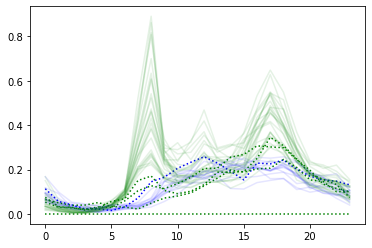

In [27]:
preds = (model(X_test) > 0).detach().int().numpy()
trues = y_test.numpy()

for i in range(len(X_test)):
    plt.plot(np.arange(24), X_test[i, :, 0].numpy(),
             color = ["blue", "green"][int(trues[i])],
             ls = [":", "-"][int(trues[i] == preds[i])],
             alpha = [1, 0.1][int(trues[i] == preds[i])])
